# 🛰️ Extração de Features de Sinais de GNSS

### **Projeto de Sinais e Sistemas (Parte 1)**

Esse notebook implementa a extração dos sinais de GNSS e das suas features, usadas posteriormente para detecção de spoofing, utilizando métricas extraídas de correlações e características retiradas dos sinais dos datasets FGI SpoofRepo e FGI OSNMA.

As features extraídas foram as seguintes:
- **block_idx**: índice do bloco de dados processado;
- **time_s**: tempo em segundos da amostra;
- **best_prn**: PRN que apresentou a melhor correlação;
- **best_doppler**: frequência de Doppler que apresentou a melhor correlação;
- **best_tau_chips**: atraso em chips que apresentou a melhor correlação;
- **peak_snr**: relação sinal-ruído (SNR) no pico de correlação;
- **peak_raw**: valor do sinal bruto no pico de correlação;
- **in_phase_lag**: atraso em chips da componente em fase (I) no pico de correlação;

## Instalação das bibliotecas necessárias

In [58]:
%pip install scipy numpy matplotlib pyyaml pandas --quiet

Note: you may need to restart the kernel to use updated packages.


## Importação de bibliotecas necessárias

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import yaml
import os
from scipy import signal


## Obtenção de parâmetros gerais do dataset

In [60]:
def get_params(config):
    ds = config['DATASET']
    rf = config['RF_FRONT_END']
    gps = config['GPS_STANDARD']
    acq = config['ACQUISITION']
    
    FILENAME = ds['FILENAME']
    # Converte a 'int8' para np.int8
    DATA_DTYPE = getattr(np, ds['DTYPE'])

    FS = rf['FS'] # Frequência de amostragem
    FC = rf['FC'] # Frequência central (deslocamento resultante da modulação)

    PRN_CHIP_RATE = gps['PRN_CHIP_RATE'] # Taxa de chips do PRN
    PRN_LENGTH = gps['PRN_LENGTH'] # Comprimento do PRN (em chips)

    # O que são chips?
    # Chips são os elementos básicos do código PRN (Pseudo-Random Noise) usado em sistemas GNSS para identificação e sincronização dos sinais.
    # Cada chip representa um bit do código PRN, e a taxa de chips indica quantos desses bits são transmitidos por segundo.
    
    DOPPLER_RANGE = acq['DOPPLER_RANGE'] # Faixa de Doppler a ser pesquisada
    DOPPLER_STEP = acq['DOPPLER_STEP'] # Passo de Doppler para a pesquisa
    TIME_TO_PROCESS = acq['TIME_TO_PROCESS'] # Tempo de dados a serem processados (em segundos)

    # O que é Doppler?
    # O efeito Doppler é a mudança na frequência percebida de uma onda em relação ao observador, causada pelo movimento relativo entre a fonte da onda e o observador.
    # Em GNSS, o efeito Doppler afeta a frequência dos sinais recebidos dos satélites devido ao movimento relativo entre os satélites e o receptor na Terra.
    
    # Amostras por Chip (define o superamostragem da réplica do código)
    SAMPLES_PER_CHIP = round(FS / PRN_CHIP_RATE)

    # Amostras em um Período de Código (em amostras)
    SAMPLES_PER_CODE = PRN_LENGTH * SAMPLES_PER_CHIP

    # Número de Amostras para Integração Coerente (idealmente 1ms ou múltiplo)
    N_SAMPLES_COHERENT = int(FS * TIME_TO_PROCESS)

    # Garante que o bloco de amostras seja um múltiplo exato do período do código,
    # essencial para a correlação cíclica (FFT).
    N_SAMPLES_COHERENT = (N_SAMPLES_COHERENT // SAMPLES_PER_CODE) * SAMPLES_PER_CODE

    # Se o bloco calculado for 0 (por exemplo TIME_TO_PROCESS muito curto),
    # faça fallback para processar ao menos um período de código (evita FFT de tamanho 0)
    if N_SAMPLES_COHERENT == 0:
        N_SAMPLES_COHERENT = SAMPLES_PER_CODE

    return {
        'FILENAME': FILENAME, 
        'DTYPE': DATA_DTYPE,
        'FS': FS, 
        'FC': FC, 
        'PRN_CHIP_RATE': PRN_CHIP_RATE, 
        'PRN_LENGTH': PRN_LENGTH,
        'DOPPLER_RANGE': DOPPLER_RANGE, 
        'DOPPLER_STEP': DOPPLER_STEP, 
        'TIME_TO_PROCESS': TIME_TO_PROCESS,
        'SAMPLES_PER_CHIP': SAMPLES_PER_CHIP,
        'SAMPLES_PER_CODE': SAMPLES_PER_CODE,
        'N_SAMPLES_COHERENT': N_SAMPLES_COHERENT
    }

def load_config(config_file):
    try:
        with open(config_file, 'r') as f:
            config = yaml.safe_load(f)
        return config
    except FileNotFoundError:
        raise FileNotFoundError(f"Erro: Arquivo de configuração '{config_file}' não encontrado.")
    except yaml.YAMLError as e:
        raise ValueError(f"Erro ao decodificar YAML: {e}")

CONFIG_CLEAN_PATH = os.path.join("config", "fgi", "config_clean.yaml")
CONFIG_SPOOFED_PATH = os.path.join("config", "fgi", "config_spoofed.yaml")

config_clean_data = load_config(CONFIG_CLEAN_PATH)
config_spoofed_data = load_config(CONFIG_SPOOFED_PATH)

PARAMS_CLEAN = get_params(config_clean_data)
PARAMS_SPOOFED = get_params(config_spoofed_data)

print(f"Amostras por chip (CLEAN): {PARAMS_CLEAN['SAMPLES_PER_CHIP']}")
print(f"Amostras por chip (SPOOFED): {PARAMS_SPOOFED['SAMPLES_PER_CHIP']}")

Amostras por chip (CLEAN): 25
Amostras por chip (SPOOFED): 25


## Demodulação do sinal pela frequência central

In [61]:
def demodulate(gps_complex, N_samples, Fs, FC_local):
    t = np.arange(N_samples) / Fs
    omega_0 = 2 * np.pi * FC_local
    demodulation_factor = np.exp((-1) * 1j * omega_0 * t)
    return gps_complex * demodulation_factor # f(t)e^(-jω0t) <=> F(f + ω0)

## Geração do código PRN GPS

In [62]:
# Mapeamento dos PRN IDs
PRN_G2_TAPS = [
    [2, 6], [3, 7], [4, 8], [5, 9], [1, 9], [2, 10], [1, 8], [2, 9], 
    [3, 10], [2, 3], [3, 4], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], 
    [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [1, 3], [4, 6], 
    [5, 7], [6, 8], [7, 9], [8, 10], [1, 6], [2, 7], [3, 8], [4, 9], 
    [5, 10], [4, 10], [1, 7], [2, 8], [4, 10]
]

def generate_ca_code(prn_id, fs, samples_per_code, code_length=1023, chip_rate=1.023e6):
    sv_index = prn_id - 1

    if prn_id < 1 or prn_id > len(PRN_G2_TAPS):
        raise ValueError("PRN ID inválido (fora do intervalo 1-37).")

    # Inicialização: G1 e G2 com todos os 1s (usando 0/1 para lógica binária)
    LFSR_LEN = 10
    g1 = np.ones(LFSR_LEN, dtype=int)
    g2 = np.ones(LFSR_LEN, dtype=int)

    ca_code_chips = np.zeros(code_length, dtype=int)

    # Taps G2 específicas do satélite (posições de 1 a 10)
    g2_taps = PRN_G2_TAPS[sv_index]

    for i in range(code_length):
        # Saída dos registradores
        out_g1 = g1[9]
        out_g2 = g2[g2_taps[0] - 1] ^ g2[g2_taps[1] - 1]

        ca_chip_binary = out_g1 ^ out_g2
        ca_code_chips[i] = ca_chip_binary

        # Feedbacks
        feedback_g1 = g1[2] ^ g1[9]
        feedback_g2 = g2[1] ^ g2[2] ^ g2[5] ^ g2[7] ^ g2[8] ^ g2[9]

        g1 = np.roll(g1, 1)
        g1[0] = feedback_g1

        g2 = np.roll(g2, 1)
        g2[0] = feedback_g2

    # Conversão de chips (0, 1) para (-1, +1)
    bipolar_code_chips = 2 * ca_code_chips - 1

    # --- ALTERAÇÃO: Amostragem correta baseada no tempo em vez de repetição ---
    # Cria vetor de tempo para 1ms (ou o período do código)
    t = np.arange(samples_per_code) / fs
    
    # Calcula em qual chip estamos para cada instante de tempo
    # t * chip_rate dá o índice do chip (float), .astype(int) pega o índice inteiro
    chip_indices = (t * chip_rate).astype(int) % code_length
    
    # Mapeia os índices para os valores do código
    sampled_code = bipolar_code_chips[chip_indices]

    return sampled_code

## Correlação entre o sinal recebido e a réplica do código PRN GPS

In [63]:
def normalize_correlation_by_noise(correlation_magnitude, samples_per_code, prn_length):
    # Acha a posição exata e o valor do pico bruto
    phase = np.argmax(correlation_magnitude)

    # Define a largura de exclusão ao redor do pico (1.5 chips)
    # samples_per_code / prn_length = samples_per_chip.
    samples_per_chip = samples_per_code / prn_length
    exclude_samples = int(1.5 * samples_per_chip)
    
    # Define os limites de exclusão
    start = max(0, phase - exclude_samples)
    end = min(len(correlation_magnitude), phase + exclude_samples)

    # Calcula o nível de ruído
    # Concatena os valores antes e depois da área do pico
    noise_values = np.concatenate([correlation_magnitude[:start], correlation_magnitude[end:]])
    
    # Usa a MEDIANA como medida robusta do chão de ruído (Noise Floor)
    if len(noise_values) == 0:
        # Fallback se o array for muito pequeno
        noise_level = np.median(correlation_magnitude) 
    else:
        noise_level = np.median(noise_values)

    # Normalização
    if noise_level < 1e-9: # Evita divisão por zero ou por um número muito pequeno
        noise_level = 1e-9

    corr_normalized = correlation_magnitude / noise_level

    # Valor do pico normalizado (SNR do Pico)
    peak_normalized = corr_normalized[phase]

    return corr_normalized, peak_normalized, phase

def correlate_signals(band_base_signal, local_code_replica):
    fft_signal = np.fft.fft(band_base_signal)
    fft_code_replica = np.fft.fft(local_code_replica)

    # Correlação no domínio da frequência é apenas a multiplicação do FFT do sinal pelo conjugado do FFT da réplica do código
    fft_product = fft_signal * np.conjugate(fft_code_replica)
    
    correlation_result = np.fft.ifft(fft_product)

    return np.abs(correlation_result)

In [64]:
def acquire_gnss_signal(filepath):

    print(f"\nIniciando aquisição GNSS para o arquivo: {filepath}\n")

    filename = os.path.basename(filepath)

    if "clean" in filename:
        cfg = PARAMS_CLEAN
    elif "TGS" in filename:
        cfg = PARAMS_SPOOFED

    BLOCK_TIME = 0.001  # 1 ms por bloco
    TOTAL_TIME = cfg["TIME_TO_PROCESS"]  # Tempo total a processar
    
    samples_per_block = int(cfg["FS"] * BLOCK_TIME)
    
    total_samples = int(cfg["FS"] * TOTAL_TIME)
    num_blocks = total_samples // samples_per_block
    
    # --- ALTERAÇÃO: Downsampling para 1 amostra por chip ---
    # O objetivo é ter 1023 amostras por bloco de 1ms
    target_samples_per_block = cfg["PRN_LENGTH"] 
    
    print(f"Processando {num_blocks} blocos de {BLOCK_TIME*1000:.1f} ms cada")
    print(f"Tempo total: {TOTAL_TIME} segundos")
    print(f"Amostras originais por bloco: {samples_per_block}")
    print(f"Amostras após downsampling: {target_samples_per_block}")

    try:
        print(f"\nLendo arquivo: {filepath}")
        raw_data = np.fromfile(filepath, dtype=cfg["DTYPE"], count=total_samples)
        
        if len(raw_data) < total_samples:
            print(f"Aviso: Arquivo tem apenas {len(raw_data)} amostras ({len(raw_data)/cfg['FS']:.2f}s)")
            num_blocks = len(raw_data) // samples_per_block
            print(f"Ajustando para {num_blocks} blocos")
        
        raw_data = raw_data.astype(np.float32)
        
    except FileNotFoundError:
        print(f"Erro: Arquivo '{filepath}' não encontrado.")
        return

    # Armazenamento das métricas de cada amostra
    results = {
        'block_idx': [],
        'time_s': [],
        'best_prn': [],
        'best_doppler': [],
        'best_tau_chips': [],
        'peak_snr': [],
        'peak_raw': [],
        'in_phase_lag': [],
        'correlation_width': []
    }

    prn_codes = {}
    for prn in range(1, 33):
        # Gerar código com exatamente 1023 amostras (1 amostra por chip)
        # Usamos chip_rate como fs para gerar 1 amostra por chip
        prn_codes[prn] = generate_ca_code(prn, cfg["PRN_CHIP_RATE"], target_samples_per_block)

    doppler_freqs = np.arange(-cfg["DOPPLER_RANGE"], cfg["DOPPLER_RANGE"] + cfg["DOPPLER_STEP"], cfg["DOPPLER_STEP"])

    for block_idx in range(num_blocks):
        start_sample = block_idx * samples_per_block
        end_sample = start_sample + samples_per_block
        
        block_data = raw_data[start_sample:end_sample]
        gps_complex = block_data + 1j * np.zeros_like(block_data)
        N_block_original = len(gps_complex)
        
        max_correlation_value = 0.0
        best_doppler = 0.0
        best_tau = 0
        best_prn = 0
        best_code_replica = None
        
        # Busca pelo melhor PRN e Doppler
        for prn in range(1, 33):
            local_code_chips = prn_codes[prn]
            local_code_replica = local_code_chips 
            
            for doppler in doppler_freqs:
                FC_local = cfg["FC"] + doppler
                # 1. Demodular na taxa original
                band_base_signal_high_res = demodulate(gps_complex, N_block_original, cfg["FS"], FC_local)
                
                # 2. Fazer resample para 1023 amostras
                band_base_signal = signal.resample(band_base_signal_high_res, target_samples_per_block)
                
                correlation_magnitude = correlate_signals(band_base_signal, local_code_replica)
                current_max = np.max(correlation_magnitude)
                
                if current_max > max_correlation_value:
                    max_correlation_value = current_max
                    best_doppler = doppler
                    best_tau = np.argmax(correlation_magnitude)
                    best_prn = prn
                    best_code_replica = local_code_replica.copy()
        
        # Calcular SNR normalizado
        final_fc_local = cfg["FC"] + best_doppler
        final_band_base_high_res = demodulate(gps_complex, N_block_original, cfg["FS"], final_fc_local)
        final_band_base = signal.resample(final_band_base_high_res, target_samples_per_block)
        
        final_correlation = correlate_signals(final_band_base, best_code_replica)
        
        # Agora samples_per_code é igual a prn_length (1023)
        _, peak_snr, peak_phase = normalize_correlation_by_noise(final_correlation, target_samples_per_block, cfg['PRN_LENGTH'])
        
        # Samples per chip agora é 1
        real_samples_per_chip = 1.0

        # Atraso de código entre blocos consecutivos
        if block_idx > 0:
            prev_tau = results['best_tau_chips'][-1]
            current_tau = best_tau # Já está em chips pois samples_per_chip = 1
            # Tratar wrap-around (quando τ vai de ~1023 para ~0)
            tau_diff = current_tau - prev_tau
            if abs(tau_diff) > cfg['PRN_LENGTH'] / 2:
                tau_diff = tau_diff - np.sign(tau_diff) * cfg['PRN_LENGTH']
            in_phase_lag = tau_diff
        else:
            in_phase_lag = 0.0

        # Largura do pico de correlação
        peak_value = final_correlation[peak_phase]
        half_peak = peak_value * 0.5
        above_half = final_correlation > half_peak
        correlation_width = np.sum(above_half) # Já está em chips
        
        # Armazenar resultados
        time_s = block_idx * BLOCK_TIME
        tau_chips = best_tau # Já está em chips
        
        # Adição das features à lista de resultados
        results['block_idx'].append(block_idx)
        results['time_s'].append(time_s)
        results['best_prn'].append(best_prn)
        results['best_doppler'].append(best_doppler)
        results['best_tau_chips'].append(tau_chips)
        results['peak_snr'].append(peak_snr)
        results['peak_raw'].append(max_correlation_value)
        results['in_phase_lag'].append(in_phase_lag)
        results['correlation_width'].append(correlation_width)
        
        # Progresso a cada 100 blocos (0.1 segundo)
        if (block_idx + 1) % 100 == 0:
            print(f"Bloco {block_idx + 1}/{num_blocks} ({time_s:.2f}s) - PRN {best_prn}, Doppler {best_doppler:.0f} Hz, SNR {peak_snr:.2f}")

    for key in results:
        results[key] = np.array(results[key])

    _, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    # SNR ao longo do tempo
    axes[0].plot(results['time_s'], results['peak_snr'], 'b-', linewidth=0.5)
    axes[0].set_ylabel('SNR (normalizado)')
    axes[0].set_title(f'Evolução Temporal - {filename}')
    axes[0].grid(True)
    
    # PRN detectado
    axes[1].plot(results['time_s'], results['best_prn'], 'g.', markersize=1)
    axes[1].set_ylabel('PRN Detectado')
    axes[1].set_ylim(0, 33)
    axes[1].grid(True)
    
    # Doppler
    axes[2].plot(results['time_s'], results['best_doppler'], 'r-', linewidth=0.5)
    axes[2].set_ylabel('Doppler (Hz)')
    axes[2].grid(True)
    
    # Atraso de código (tau)
    axes[3].plot(results['time_s'], results['best_tau_chips'], 'm-', linewidth=0.5)
    axes[3].set_ylabel('Atraso τ (chips)')
    axes[3].set_xlabel('Tempo (s)')
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

    print("\n--- Estatísticas Gerais ---")
    print(f"Blocos processados: {num_blocks}")
    print(f"SNR médio: {np.mean(results['peak_snr']):.2f}")
    print(f"SNR máximo: {np.max(results['peak_snr']):.2f}")
    print(f"PRN mais frequente: {np.bincount(results['best_prn'].astype(int)).argmax()}")
    print(f"Doppler médio: {np.mean(results['best_doppler']):.1f} Hz")
    
    return results


## Plotagem dos resultados da análise de spoofing

PROCESSANDO SINAL AUTÊNTICO

Iniciando aquisição GNSS para o arquivo: /home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat

Processando 50 blocos de 1.0 ms cada
Tempo total: 0.05 segundos
Amostras originais por bloco: 26000
Amostras após downsampling: 1023

Lendo arquivo: /home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat


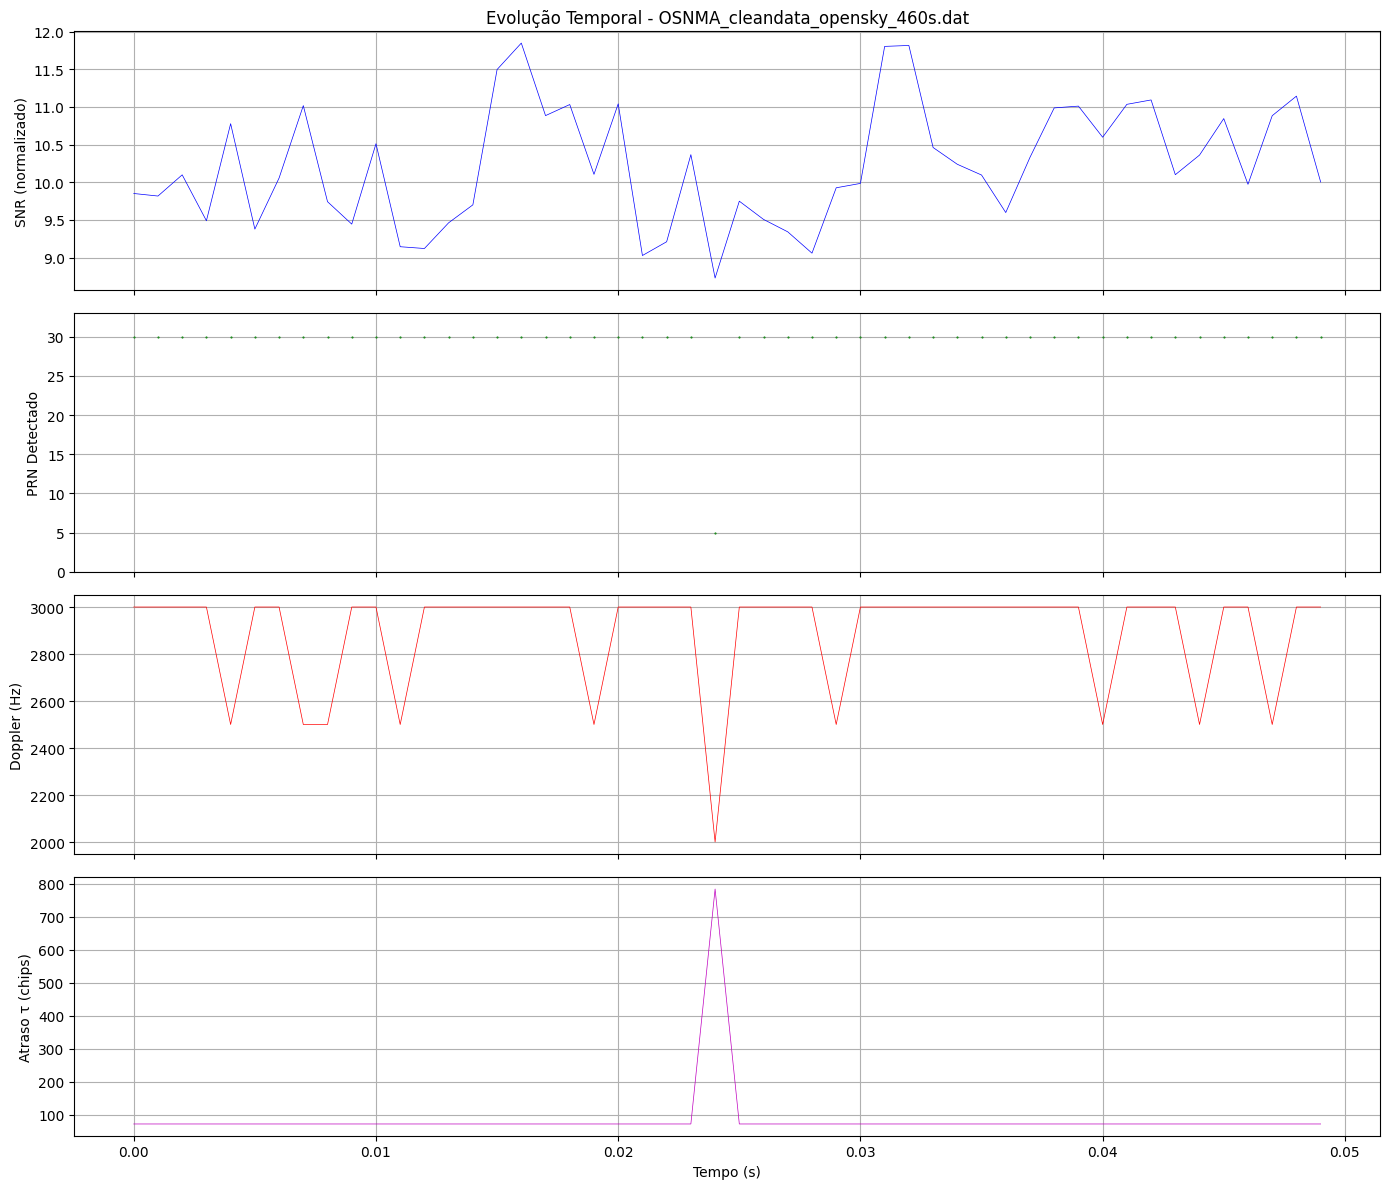


--- Estatísticas Gerais ---
Blocos processados: 50
SNR médio: 10.23
SNR máximo: 11.85
PRN mais frequente: 30
Doppler médio: 2890.0 Hz

PROCESSANDO SINAL SPOOFED

Iniciando aquisição GNSS para o arquivo: /home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat

Processando 50 blocos de 1.0 ms cada
Tempo total: 0.05 segundos
Amostras originais por bloco: 26000
Amostras após downsampling: 1023

Lendo arquivo: /home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat


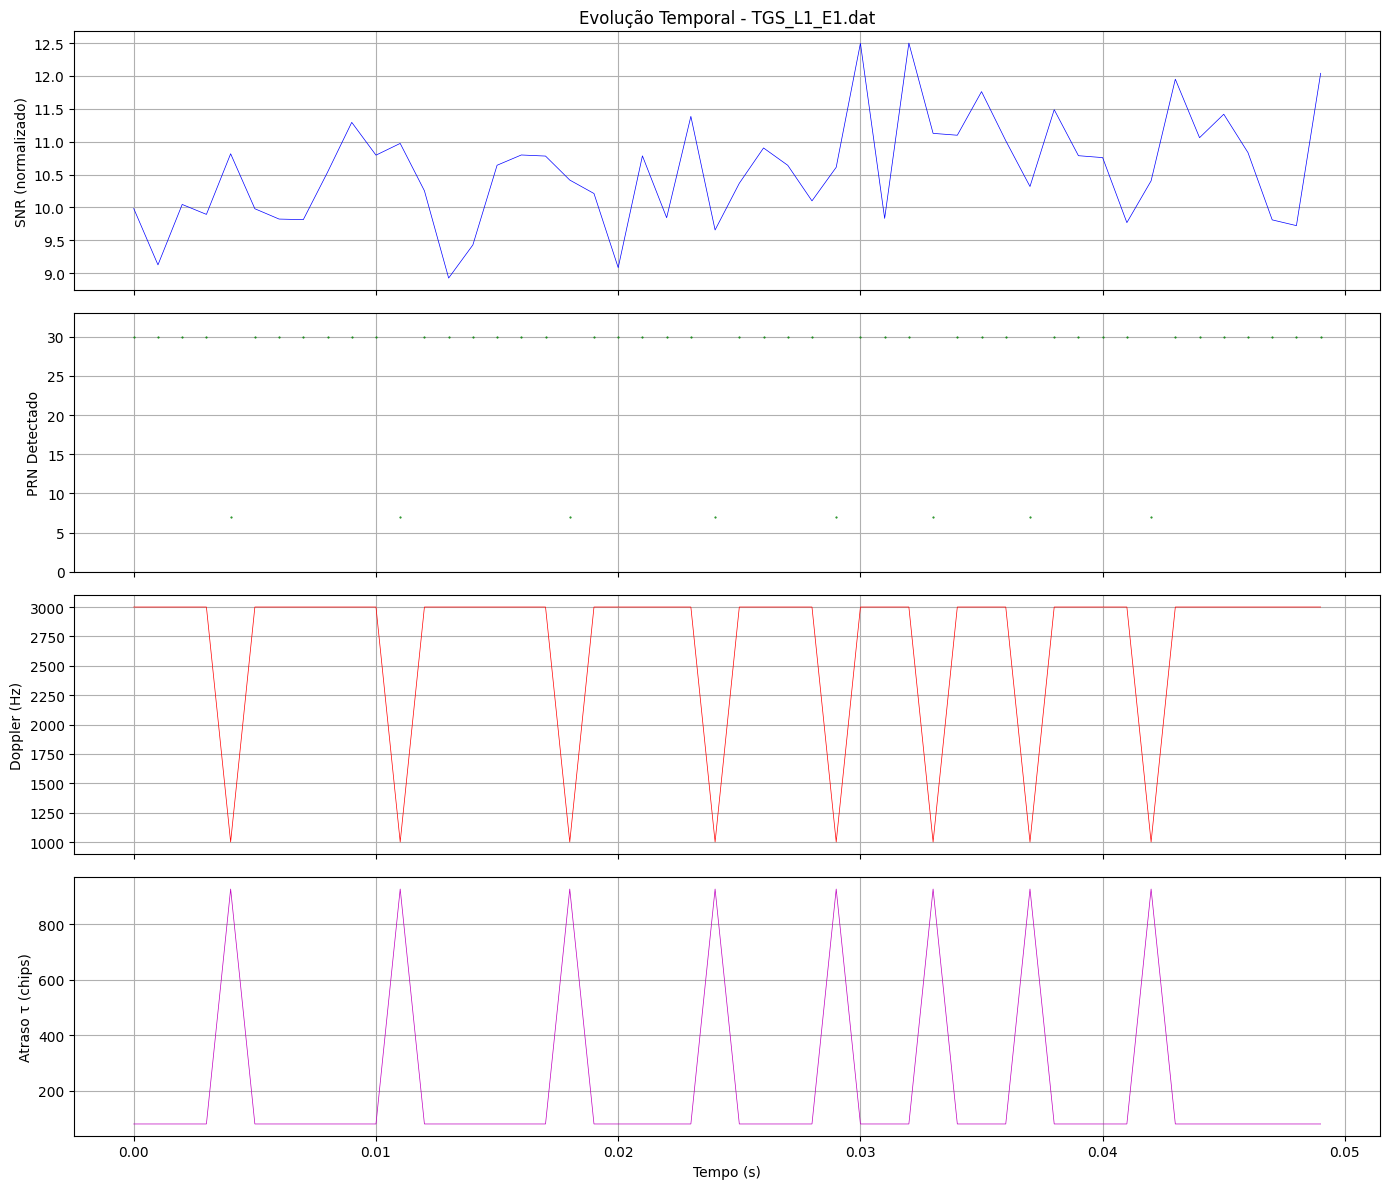


--- Estatísticas Gerais ---
Blocos processados: 50
SNR médio: 10.56
SNR máximo: 12.50
PRN mais frequente: 30
Doppler médio: 2680.0 Hz


In [65]:
FILENAME_CLEAN = '/home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat'
FILENAME_SPOOFED = '/home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat'

# Diretório para salvar os CSVs
OUTPUT_DIR = '/home/rc-2d/gnss-spoofing-detection/data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("PROCESSANDO SINAL AUTÊNTICO")
results_clean = acquire_gnss_signal(FILENAME_CLEAN)

print("\nPROCESSANDO SINAL SPOOFED")
results_spoofed = acquire_gnss_signal(FILENAME_SPOOFED)

## Obtenção das métricas de spoofing

In [66]:
def calculate_spoofing_metrics(results, cfg):

    metrics = {}
    
    # ============ 1. SNR Statistics ============
    # Sinais spoofed geralmente têm SNR mais alto e mais estável
    snr_values = results['peak_snr']
    metrics['snr_mean'] = np.mean(snr_values)
    metrics['snr_std'] = np.std(snr_values)
    metrics['snr_max'] = np.max(snr_values)
    metrics['snr_min'] = np.min(snr_values)
    metrics['snr_cv'] = metrics['snr_std'] / metrics['snr_mean'] if metrics['snr_mean'] > 0 else 0  # Coeficiente de variação
    
    # Threshold: SNR muito alto pode indicar spoofing
    SNR_THRESHOLD_HIGH = 15.0  # Ajustar conforme necessário
    metrics['snr_above_threshold'] = np.sum(snr_values > SNR_THRESHOLD_HIGH) / len(snr_values) * 100
    
    # ============ 2. Doppler Consistency ============
    # Doppler deve variar suavemente para satélites reais
    doppler_values = results['best_doppler']
    metrics['doppler_mean'] = np.mean(doppler_values)
    metrics['doppler_std'] = np.std(doppler_values)
    
    # Taxa de variação do Doppler (deve ser suave para sinais legítimos)
    doppler_diff = np.diff(doppler_values)
    metrics['doppler_rate_mean'] = np.mean(np.abs(doppler_diff))
    metrics['doppler_rate_max'] = np.max(np.abs(doppler_diff))
    
    # Saltos abruptos de Doppler (indicador de spoofing)
    DOPPLER_JUMP_THRESHOLD = 500  # Hz
    metrics['doppler_jumps'] = np.sum(np.abs(doppler_diff) > DOPPLER_JUMP_THRESHOLD)
    metrics['doppler_jump_rate'] = metrics['doppler_jumps'] / len(doppler_diff) * 100
    
    # ============ 3. Code Phase (τ) Consistency ============
    # O atraso de código deve variar suavemente
    tau_values = results['best_tau_chips']
    metrics['tau_mean'] = np.mean(tau_values)
    metrics['tau_std'] = np.std(tau_values)
    
    # Taxa de variação do τ
    tau_diff = np.diff(tau_values)
    # Tratar wrap-around (quando τ vai de ~1023 para ~0)
    tau_diff = np.where(np.abs(tau_diff) > cfg['PRN_LENGTH']/2, 
                        tau_diff - np.sign(tau_diff) * cfg['PRN_LENGTH'], 
                        tau_diff)
    metrics['tau_rate_mean'] = np.mean(np.abs(tau_diff))
    metrics['tau_rate_std'] = np.std(tau_diff)
    
    # ============ 4. PRN Diversity ============
    # Sinais legítimos devem mostrar múltiplos PRNs visíveis
    prn_values = results['best_prn']
    unique_prns = np.unique(prn_values)
    metrics['prn_unique_count'] = len(unique_prns)
    metrics['prn_unique_list'] = unique_prns.tolist()
    
    # PRN dominante e sua frequência
    prn_counts = np.bincount(prn_values.astype(int), minlength=33)
    metrics['prn_dominant'] = np.argmax(prn_counts)
    metrics['prn_dominant_ratio'] = prn_counts[metrics['prn_dominant']] / len(prn_values) * 100
    
    # ============ 5. Power Level Analysis ============
    # Potência bruta do pico de correlação
    power_values = results['peak_raw']
    metrics['power_mean'] = np.mean(power_values)
    metrics['power_std'] = np.std(power_values)
    metrics['power_cv'] = metrics['power_std'] / metrics['power_mean'] if metrics['power_mean'] > 0 else 0
    
    # ============ 6. Temporal Correlation ============
    # Autocorrelação do SNR (sinais spoofed podem ter padrões artificiais)
    if len(snr_values) > 100:
        snr_normalized = (snr_values - np.mean(snr_values)) / (np.std(snr_values) + 1e-10)
        autocorr = np.correlate(snr_normalized[:1000], snr_normalized[:1000], mode='full')
        autocorr = autocorr[len(autocorr)//2:]  # Pegar apenas lag positivo
        autocorr = autocorr / autocorr[0]  # Normalizar
        metrics['snr_autocorr_lag1'] = autocorr[1] if len(autocorr) > 1 else 0
        metrics['snr_autocorr_lag10'] = autocorr[10] if len(autocorr) > 10 else 0
    else:
        metrics['snr_autocorr_lag1'] = 0
        metrics['snr_autocorr_lag10'] = 0
    
    # ============ 7. In-Phase Lag Analysis ============
    # Variação do atraso de fase entre blocos consecutivos
    in_phase_lag_values = results['in_phase_lag']
    metrics['in_phase_lag_mean'] = np.mean(np.abs(in_phase_lag_values))
    metrics['in_phase_lag_std'] = np.std(in_phase_lag_values)
    metrics['in_phase_lag_max'] = np.max(np.abs(in_phase_lag_values))
    
    # Saltos abruptos de fase (indicador de spoofing)
    PHASE_JUMP_THRESHOLD = 0.5  # chips
    phase_jumps = np.sum(np.abs(in_phase_lag_values) > PHASE_JUMP_THRESHOLD)
    metrics['phase_jumps'] = phase_jumps
    metrics['phase_jump_rate'] = phase_jumps / len(in_phase_lag_values) * 100
    
    # ============ 8. Correlation Width Analysis ============
    # Largura do pico de correlação (picos muito estreitos ou largos podem indicar anomalias)
    corr_width_values = results['correlation_width']
    metrics['corr_width_mean'] = np.mean(corr_width_values)
    metrics['corr_width_std'] = np.std(corr_width_values)
    metrics['corr_width_cv'] = metrics['corr_width_std'] / metrics['corr_width_mean'] if metrics['corr_width_mean'] > 0 else 0
    
    # ============ 9. Temporal Correlation ============
    # Autocorrelação do SNR (sinais spoofed podem ter padrões artificiais)
    if len(snr_values) > 100:
        snr_normalized = (snr_values - np.mean(snr_values)) / (np.std(snr_values) + 1e-10)
        autocorr = np.correlate(snr_normalized[:1000], snr_normalized[:1000], mode='full')
        autocorr = autocorr[len(autocorr)//2:]  # Pegar apenas lag positivo
        autocorr = autocorr / autocorr[0]  # Normalizar
        metrics['snr_autocorr_lag1'] = autocorr[1] if len(autocorr) > 1 else 0
        metrics['snr_autocorr_lag10'] = autocorr[10] if len(autocorr) > 10 else 0
    else:
        metrics['snr_autocorr_lag1'] = 0
        metrics['snr_autocorr_lag10'] = 0

    metrics['spoofing_score'] = 0
    
    return metrics


def print_spoofing_report(metrics, filename):
    print(f"\nRELATÓRIO DE DETECÇÃO DE SPOOFING - {filename}")
    
    print("\nESTATÍSTICAS DE SNR:")
    print(f"- Média: {metrics['snr_mean']:.2f}")
    print(f"- Desvio Padrão: {metrics['snr_std']:.2f}")
    print(f"- Coef. Variação: {metrics['snr_cv']:.3f}")
    print(f"- Máx/Mín: {metrics['snr_max']:.2f} / {metrics['snr_min']:.2f}")
    print(f"- % acima do threshold: {metrics['snr_above_threshold']:.1f}%")
    
    print("\nANÁLISE DOPPLER:")
    print(f"- Média: {metrics['doppler_mean']:.1f} Hz")
    print(f"- Desvio Padrão: {metrics['doppler_std']:.1f} Hz")
    print(f"- Taxa média de variação: {metrics['doppler_rate_mean']:.2f} Hz/ms")
    print(f"- Saltos abruptos: {metrics['doppler_jumps']} ({metrics['doppler_jump_rate']:.2f}%)")

    print("\nANÁLISE DE ATRASO (τ):")
    print(f"- Média: {metrics['tau_mean']:.2f} chips")
    print(f"- Desvio Padrão: {metrics['tau_std']:.2f} chips")
    print(f"- Taxa média de variação: {metrics['tau_rate_mean']:.4f} chips/ms")

    print("\nDIVERSIDADE DE PRN:")
    print(f"- PRNs únicos detectados: {metrics['prn_unique_count']}")
    print(f"- PRNs: {metrics['prn_unique_list']}")
    print(f"- PRN dominante: {metrics['prn_dominant']} ({metrics['prn_dominant_ratio']:.1f}%)")

    print("\nANÁLISE DE POTÊNCIA:")
    print(f"- Média: {metrics['power_mean']:.2f}")
    print(f"- Coef. Variação: {metrics['power_cv']:.3f}")

    print("\nANÁLISE DE IN-PHASE LAG:")
    print(f"- Média |lag|: {metrics['in_phase_lag_mean']:.4f} chips")
    print(f"- Desvio Padrão: {metrics['in_phase_lag_std']:.4f} chips")
    print(f"- Máximo |lag|: {metrics['in_phase_lag_max']:.4f} chips")
    print(f"- Saltos de fase: {metrics['phase_jumps']} ({metrics['phase_jump_rate']:.2f}%)")

    print("\nLARGURA DE CORRELAÇÃO:")
    print(f"- Média: {metrics['corr_width_mean']:.2f} chips")
    print(f"- Desvio Padrão: {metrics['corr_width_std']:.2f} chips")
    print(f"- Coef. Variação: {metrics['corr_width_cv']:.3f}")

    print("\nCORRELAÇÃO TEMPORAL:")
    print(f"- Autocorrelação SNR (lag=1): {metrics['snr_autocorr_lag1']:.3f}")
    print(f"- Autocorrelação SNR (lag=10): {metrics['snr_autocorr_lag10']:.3f}")
    
    return metrics


def plot_spoofing_comparison(results_clean, results_spoofed, metrics_clean, metrics_spoofed):

    _, axes = plt.subplots(3, 2, figsize=(16, 12))

    # Distribuição de SNR
    axes[0, 0].hist(results_clean['peak_snr'], bins=50, alpha=0.7, label='Clean', color='green')
    axes[0, 0].hist(results_spoofed['peak_snr'], bins=50, alpha=0.7, label='Spoofed', color='red')
    axes[0, 0].set_xlabel('SNR')
    axes[0, 0].set_ylabel('Frequência')
    axes[0, 0].set_title('Distribuição de SNR')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Distribuição de Doppler
    axes[0, 1].hist(results_clean['best_doppler'], bins=50, alpha=0.7, label='Clean', color='green')
    axes[0, 1].hist(results_spoofed['best_doppler'], bins=50, alpha=0.7, label='Spoofed', color='red')
    axes[0, 1].set_xlabel('Doppler (Hz)')
    axes[0, 1].set_ylabel('Frequência')
    axes[0, 1].set_title('Distribuição de Doppler')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Distribuição de PRN
    prn_clean = np.bincount(results_clean['best_prn'].astype(int), minlength=33)[1:]
    prn_spoofed = np.bincount(results_spoofed['best_prn'].astype(int), minlength=33)[1:]
    x = np.arange(1, 33)
    width = 0.35
    axes[1, 0].bar(x - width/2, prn_clean, width, label='Clean', color='green', alpha=0.7)
    axes[1, 0].bar(x + width/2, prn_spoofed, width, label='Spoofed', color='red', alpha=0.7)
    axes[1, 0].set_xlabel('PRN')
    axes[1, 0].set_ylabel('Contagem')
    axes[1, 0].set_title('Distribuição de PRN Detectados')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # SNR ao longo do tempo
    axes[1, 1].plot(results_clean['time_s'], results_clean['peak_snr'], 'g-', linewidth=0.5, label='Clean', alpha=0.7)
    axes[1, 1].plot(results_spoofed['time_s'], results_spoofed['peak_snr'], 'r-', linewidth=0.5, label='Spoofed', alpha=0.7)
    axes[1, 1].set_xlabel('Tempo (s)')
    axes[1, 1].set_ylabel('SNR')
    axes[1, 1].set_title('SNR ao Longo do Tempo')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    #
    categories = ['SNR\nMédia', 'SNR\nCV', 'PRN\nDiversidade', 'Doppler\nEstabilidade', 'Score\nTotal']
    clean_scores = [
        min(metrics_clean['snr_mean']/20*100, 100),
        (1 - min(metrics_clean['snr_cv'], 1)) * 100,
        min(metrics_clean['prn_unique_count']/10*100, 100),
        max(0, 100 - metrics_clean['doppler_jump_rate']*10),
        100 - metrics_clean['spoofing_score']
    ]
    spoofed_scores = [
        min(metrics_spoofed['snr_mean']/20*100, 100),
        (1 - min(metrics_spoofed['snr_cv'], 1)) * 100,
        min(metrics_spoofed['prn_unique_count']/10*100, 100),
        max(0, 100 - metrics_spoofed['doppler_jump_rate']*10),
        100 - metrics_spoofed['spoofing_score']
    ]
    
    x = np.arange(len(categories))
    axes[2, 0].bar(x - width/2, clean_scores, width, label='Clean', color='green', alpha=0.7)
    axes[2, 0].bar(x + width/2, spoofed_scores, width, label='Spoofed', color='red', alpha=0.7)
    axes[2, 0].set_ylabel('Score (0-100)')
    axes[2, 0].set_title('Comparação de Métricas')
    axes[2, 0].set_xticks(x)
    axes[2, 0].set_xticklabels(categories)
    axes[2, 0].legend()
    axes[2, 0].grid(True)
    
    # Tau variation
    axes[2, 1].plot(results_clean['time_s'], results_clean['best_tau_chips'], 'g-', linewidth=0.5, label='Clean', alpha=0.7)
    axes[2, 1].plot(results_spoofed['time_s'], results_spoofed['best_tau_chips'], 'r-', linewidth=0.5, label='Spoofed', alpha=0.7)
    axes[2, 1].set_xlabel('Tempo (s)')
    axes[2, 1].set_ylabel('τ (chips)')
    axes[2, 1].set_title('Atraso de Código ao Longo do Tempo')
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


RELATÓRIO DE DETECÇÃO DE SPOOFING - CLEAN DATA

ESTATÍSTICAS DE SNR:
- Média: 10.23
- Desvio Padrão: 0.78
- Coef. Variação: 0.076
- Máx/Mín: 11.85 / 8.73
- % acima do threshold: 0.0%

ANÁLISE DOPPLER:
- Média: 2890.0 Hz
- Desvio Padrão: 230.0 Hz
- Taxa média de variação: 204.08 Hz/ms
- Saltos abruptos: 2 (4.08%)

ANÁLISE DE ATRASO (τ):
- Média: 86.24 chips
- Desvio Padrão: 99.68 chips
- Taxa média de variação: 12.6939 chips/ms

DIVERSIDADE DE PRN:
- PRNs únicos detectados: 2
- PRNs: [5, 30]
- PRN dominante: 30 (98.0%)

ANÁLISE DE POTÊNCIA:
- Média: 205.40
- Coef. Variação: 0.090

ANÁLISE DE IN-PHASE LAG:
- Média |lag|: 12.4400 chips
- Desvio Padrão: 62.2000 chips
- Máximo |lag|: 311.0000 chips
- Saltos de fase: 2 (4.00%)

LARGURA DE CORRELAÇÃO:
- Média: 1.04 chips
- Desvio Padrão: 0.20 chips
- Coef. Variação: 0.188

CORRELAÇÃO TEMPORAL:
- Autocorrelação SNR (lag=1): 0.000
- Autocorrelação SNR (lag=10): 0.000

RELATÓRIO DE DETECÇÃO DE SPOOFING - SPOOFED DATA

ESTATÍSTICAS DE SNR:
- Méd

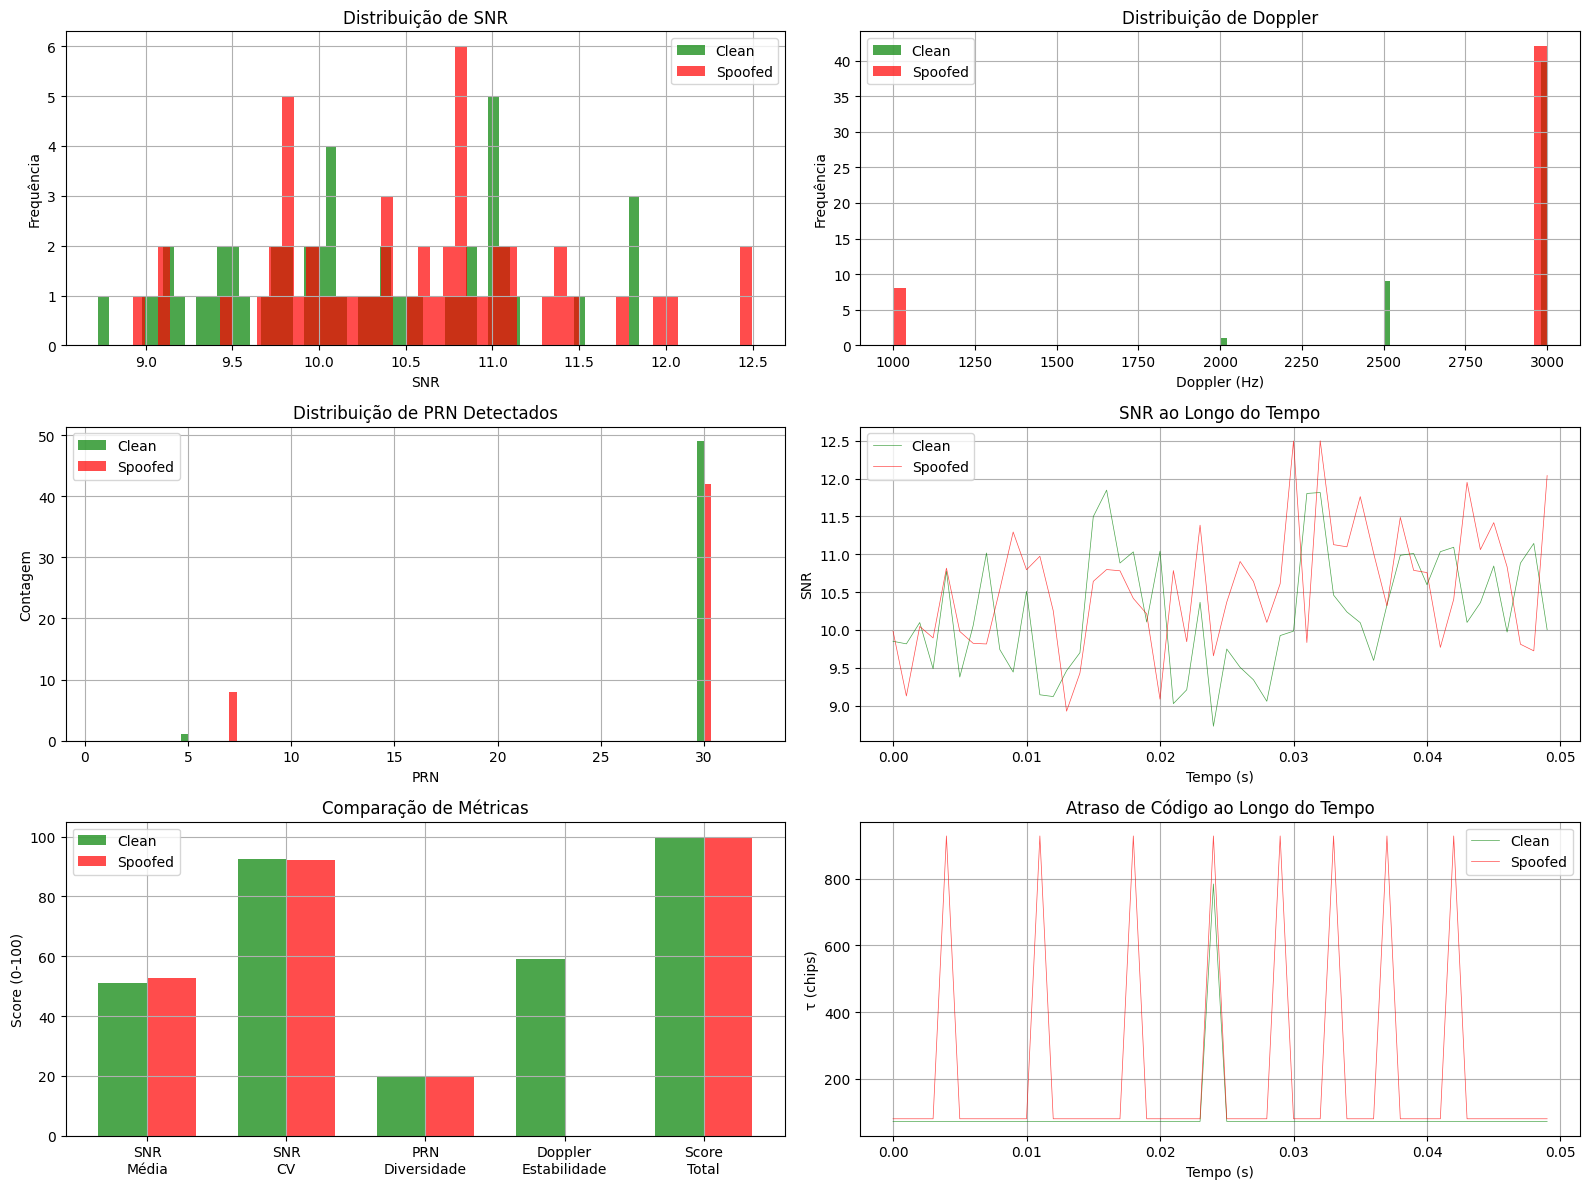


Dados autênticos salvos em: /home/rc-2d/gnss-spoofing-detection/data/gnss_clean_samples.csv
   Amostras: 50

Dados spoofed salvos em: /home/rc-2d/gnss-spoofing-detection/data/gnss_spoofed_samples.csv
   Amostras: 50

Dataset combinado salvo em: /home/rc-2d/gnss-spoofing-detection/data/gnss_dataset_labeled.csv
Total de amostras: 100
- Autênticas: 50 (50.0%)
- Spoofed: 50 (50.0%)

Métricas agregadas salvas em: /home/rc-2d/gnss-spoofing-detection/data/gnss_metrics_summary.csv

PREVIEW DO DATASET COMBINADO
   block_idx  time_s  best_prn  best_doppler  best_tau_chips   peak_snr    peak_raw  in_phase_lag  correlation_width  label label_name
0         33   0.033         7          1000             928  11.126804  210.439453        -175.0                  1      1    spoofed
1          3   0.003        30          3000              80   9.894979  184.342708           0.0                  1      1    spoofed
2         20   0.020        30          3000              80   9.085154  173.397884   

In [67]:
metrics_clean = calculate_spoofing_metrics(results_clean, PARAMS_CLEAN)
metrics_spoofed = calculate_spoofing_metrics(results_spoofed, PARAMS_SPOOFED)

print_spoofing_report(metrics_clean, "CLEAN DATA")
print_spoofing_report(metrics_spoofed, "SPOOFED DATA")

plot_spoofing_comparison(results_clean, results_spoofed, metrics_clean, metrics_spoofed)

# Criar DataFrame para dados limpos (label = 0)
df_clean = pd.DataFrame({
    'block_idx': results_clean['block_idx'],
    'time_s': results_clean['time_s'],
    'best_prn': results_clean['best_prn'],
    'best_doppler': results_clean['best_doppler'],
    'best_tau_chips': results_clean['best_tau_chips'],
    'peak_snr': results_clean['peak_snr'],
    'peak_raw': results_clean['peak_raw'],
    'in_phase_lag': results_clean['in_phase_lag'],
    'correlation_width': results_clean['correlation_width'],
    'label': 0,
    'label_name': 'authentic'
})

# Criar DataFrame para dados spoofed (label = 1)
df_spoofed = pd.DataFrame({
    'block_idx': results_spoofed['block_idx'],
    'time_s': results_spoofed['time_s'],
    'best_prn': results_spoofed['best_prn'],
    'best_doppler': results_spoofed['best_doppler'],
    'best_tau_chips': results_spoofed['best_tau_chips'],
    'peak_snr': results_spoofed['peak_snr'],
    'peak_raw': results_spoofed['peak_raw'],
    'in_phase_lag': results_spoofed['in_phase_lag'],
    'correlation_width': results_spoofed['correlation_width'],
    'label': 1,
    'label_name': 'spoofed'
})

clean_csv_path = os.path.join(OUTPUT_DIR, 'gnss_clean_samples.csv')
spoofed_csv_path = os.path.join(OUTPUT_DIR, 'gnss_spoofed_samples.csv')

df_clean.to_csv(clean_csv_path, index=False)
df_spoofed.to_csv(spoofed_csv_path, index=False)

print(f"\nDados autênticos salvos em: {clean_csv_path}")
print(f"   Amostras: {len(df_clean)}")

print(f"\nDados spoofed salvos em: {spoofed_csv_path}")
print(f"   Amostras: {len(df_spoofed)}")

df_combined = pd.concat([df_clean, df_spoofed], ignore_index=True)

df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

combined_csv_path = os.path.join(OUTPUT_DIR, 'gnss_dataset_labeled.csv')
df_combined.to_csv(combined_csv_path, index=False)

print(f"\nDataset combinado salvo em: {combined_csv_path}")
print(f"Total de amostras: {len(df_combined)}")
print(f"- Autênticas: {len(df_clean)} ({len(df_clean)/len(df_combined)*100:.1f}%)")
print(f"- Spoofed: {len(df_spoofed)} ({len(df_spoofed)/len(df_combined)*100:.1f}%)")

# Salvar métricas agregadas
metrics_df = pd.DataFrame([
    {
        'source': 'clean',
        'label': 0,
        **{k: v for k, v in metrics_clean.items() if not isinstance(v, list)}
    },
    {
        'source': 'spoofed', 
        'label': 1,
        **{k: v for k, v in metrics_spoofed.items() if not isinstance(v, list)}
    }
])

metrics_csv_path = os.path.join(OUTPUT_DIR, 'gnss_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)

print(f"\nMétricas agregadas salvas em: {metrics_csv_path}")

# Mostrar preview dos dados
print("\nPREVIEW DO DATASET COMBINADO")
print(df_combined.head(10).to_string())
print("\nESTATÍSTICAS DO DATASET")
print(df_combined.describe().to_string())

## Visualização da primeira amostra do sinal


  ANÁLISE DA PRIMEIRA AMOSTRA - SINAL LIMPO

VISUALIZAÇÃO DA PRIMEIRA AMOSTRA - OSNMA_cleandata_opensky_460s.dat
Buscando melhor PRN e Doppler...
Melhor PRN encontrado: 30
Melhor Doppler: 3000 Hz
Valor máximo de correlação: 182.32


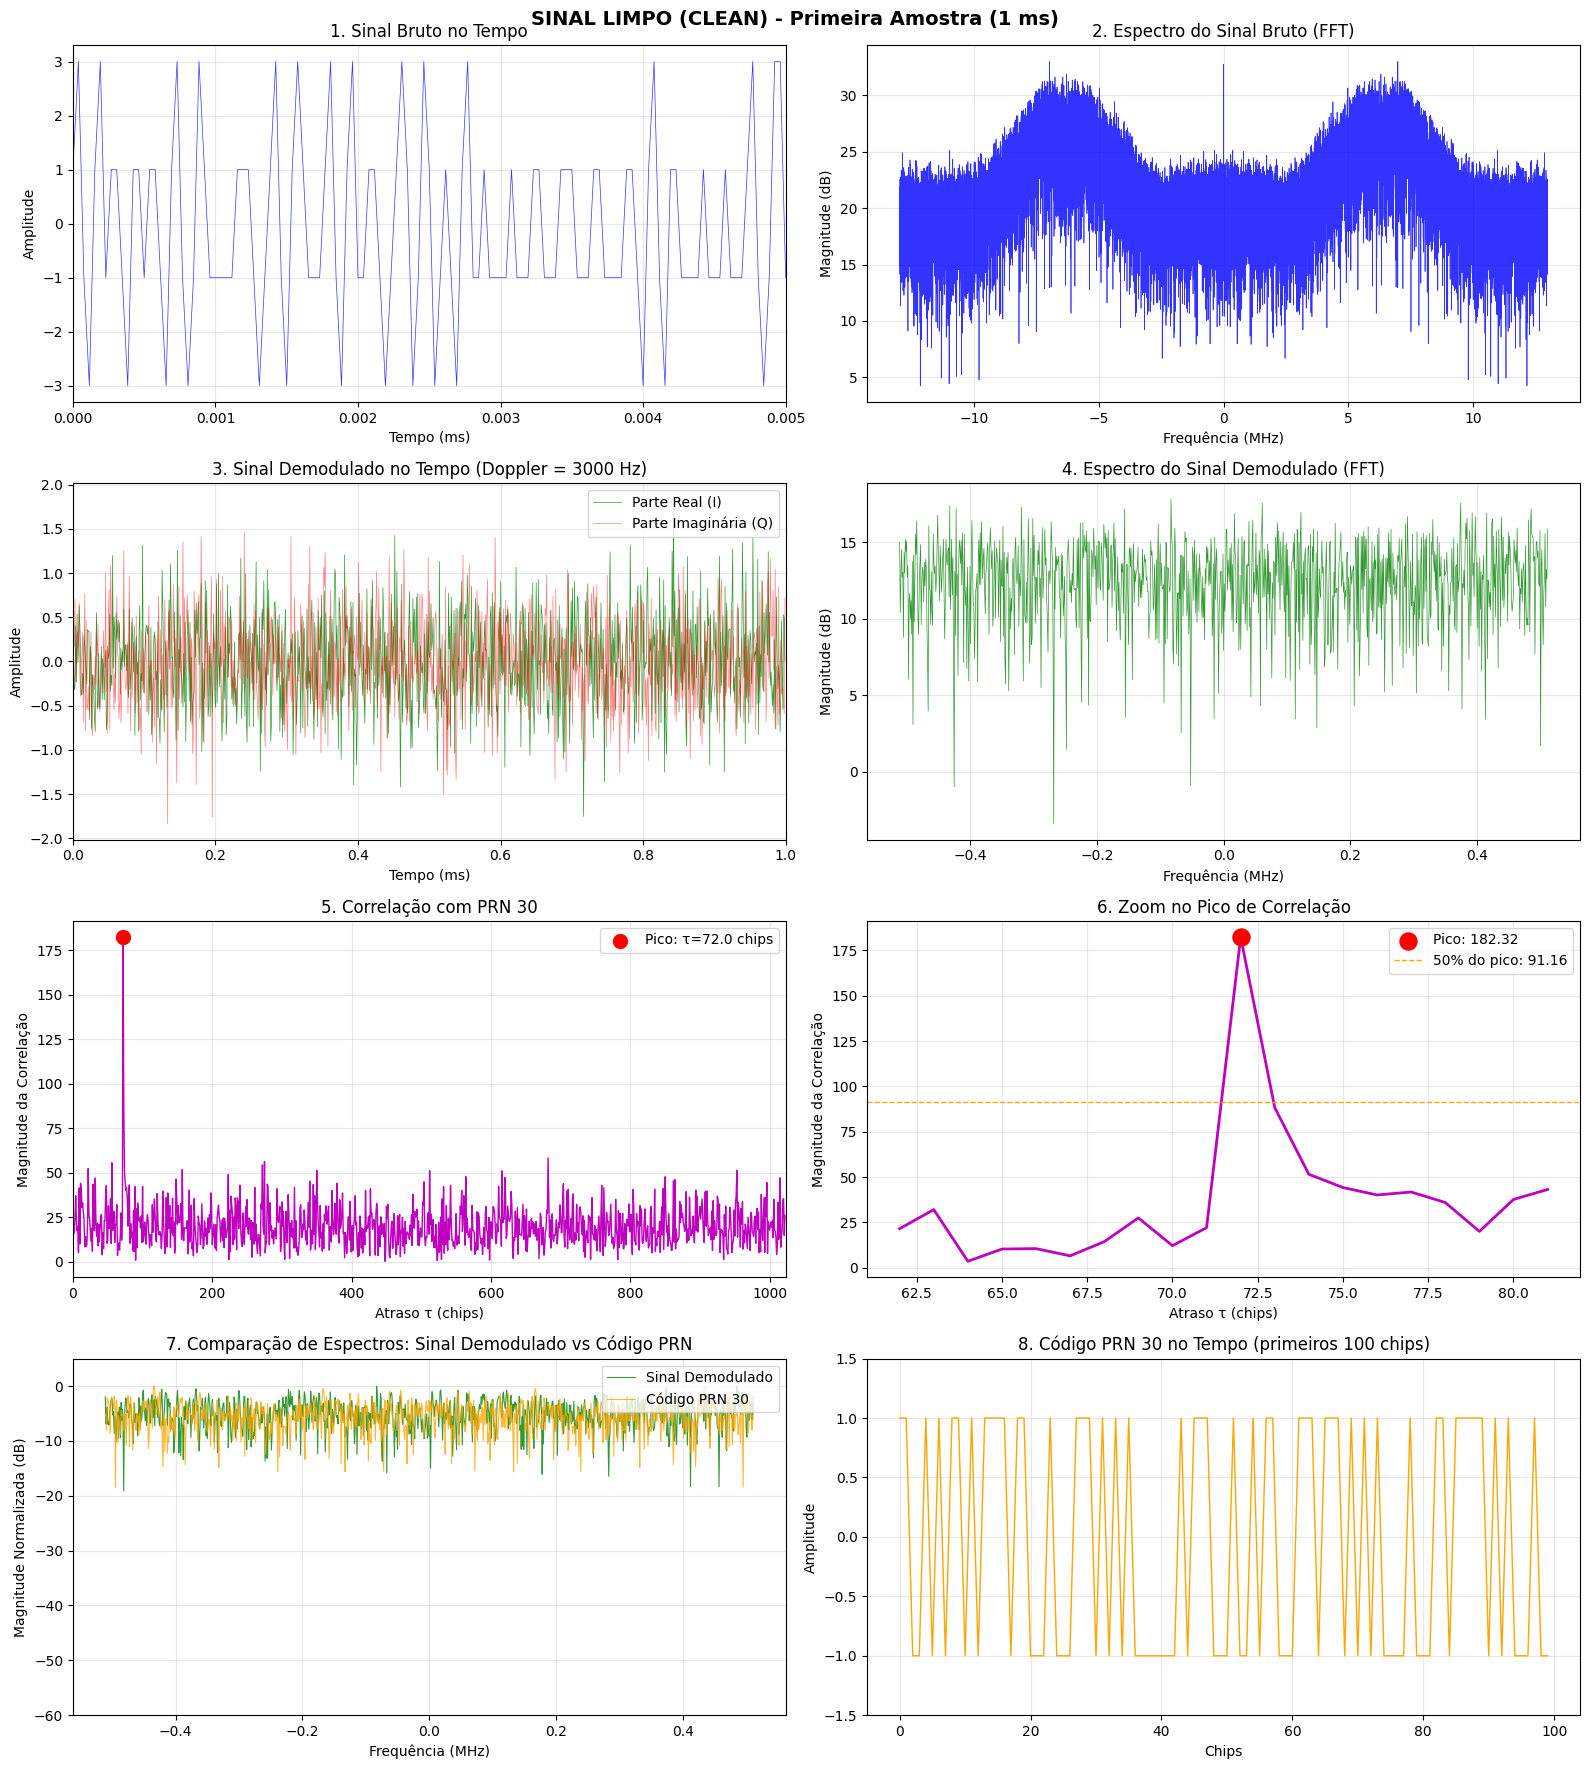


  MÉTRICAS DA PRIMEIRA AMOSTRA
  PRN detectado:        30
  Doppler:              3000 Hz
  Atraso τ:             72.00 chips
  Pico de correlação:   182.32
  SNR normalizado:      9.85
  Largura do pico:      1.00 chips
  Amostras processadas: 26000
  Duração:              1.00 ms


  ANÁLISE DA PRIMEIRA AMOSTRA - SINAL SPOOFED

VISUALIZAÇÃO DA PRIMEIRA AMOSTRA - TGS_L1_E1.dat
Buscando melhor PRN e Doppler...
Melhor PRN encontrado: 30
Melhor Doppler: 3000 Hz
Valor máximo de correlação: 195.37


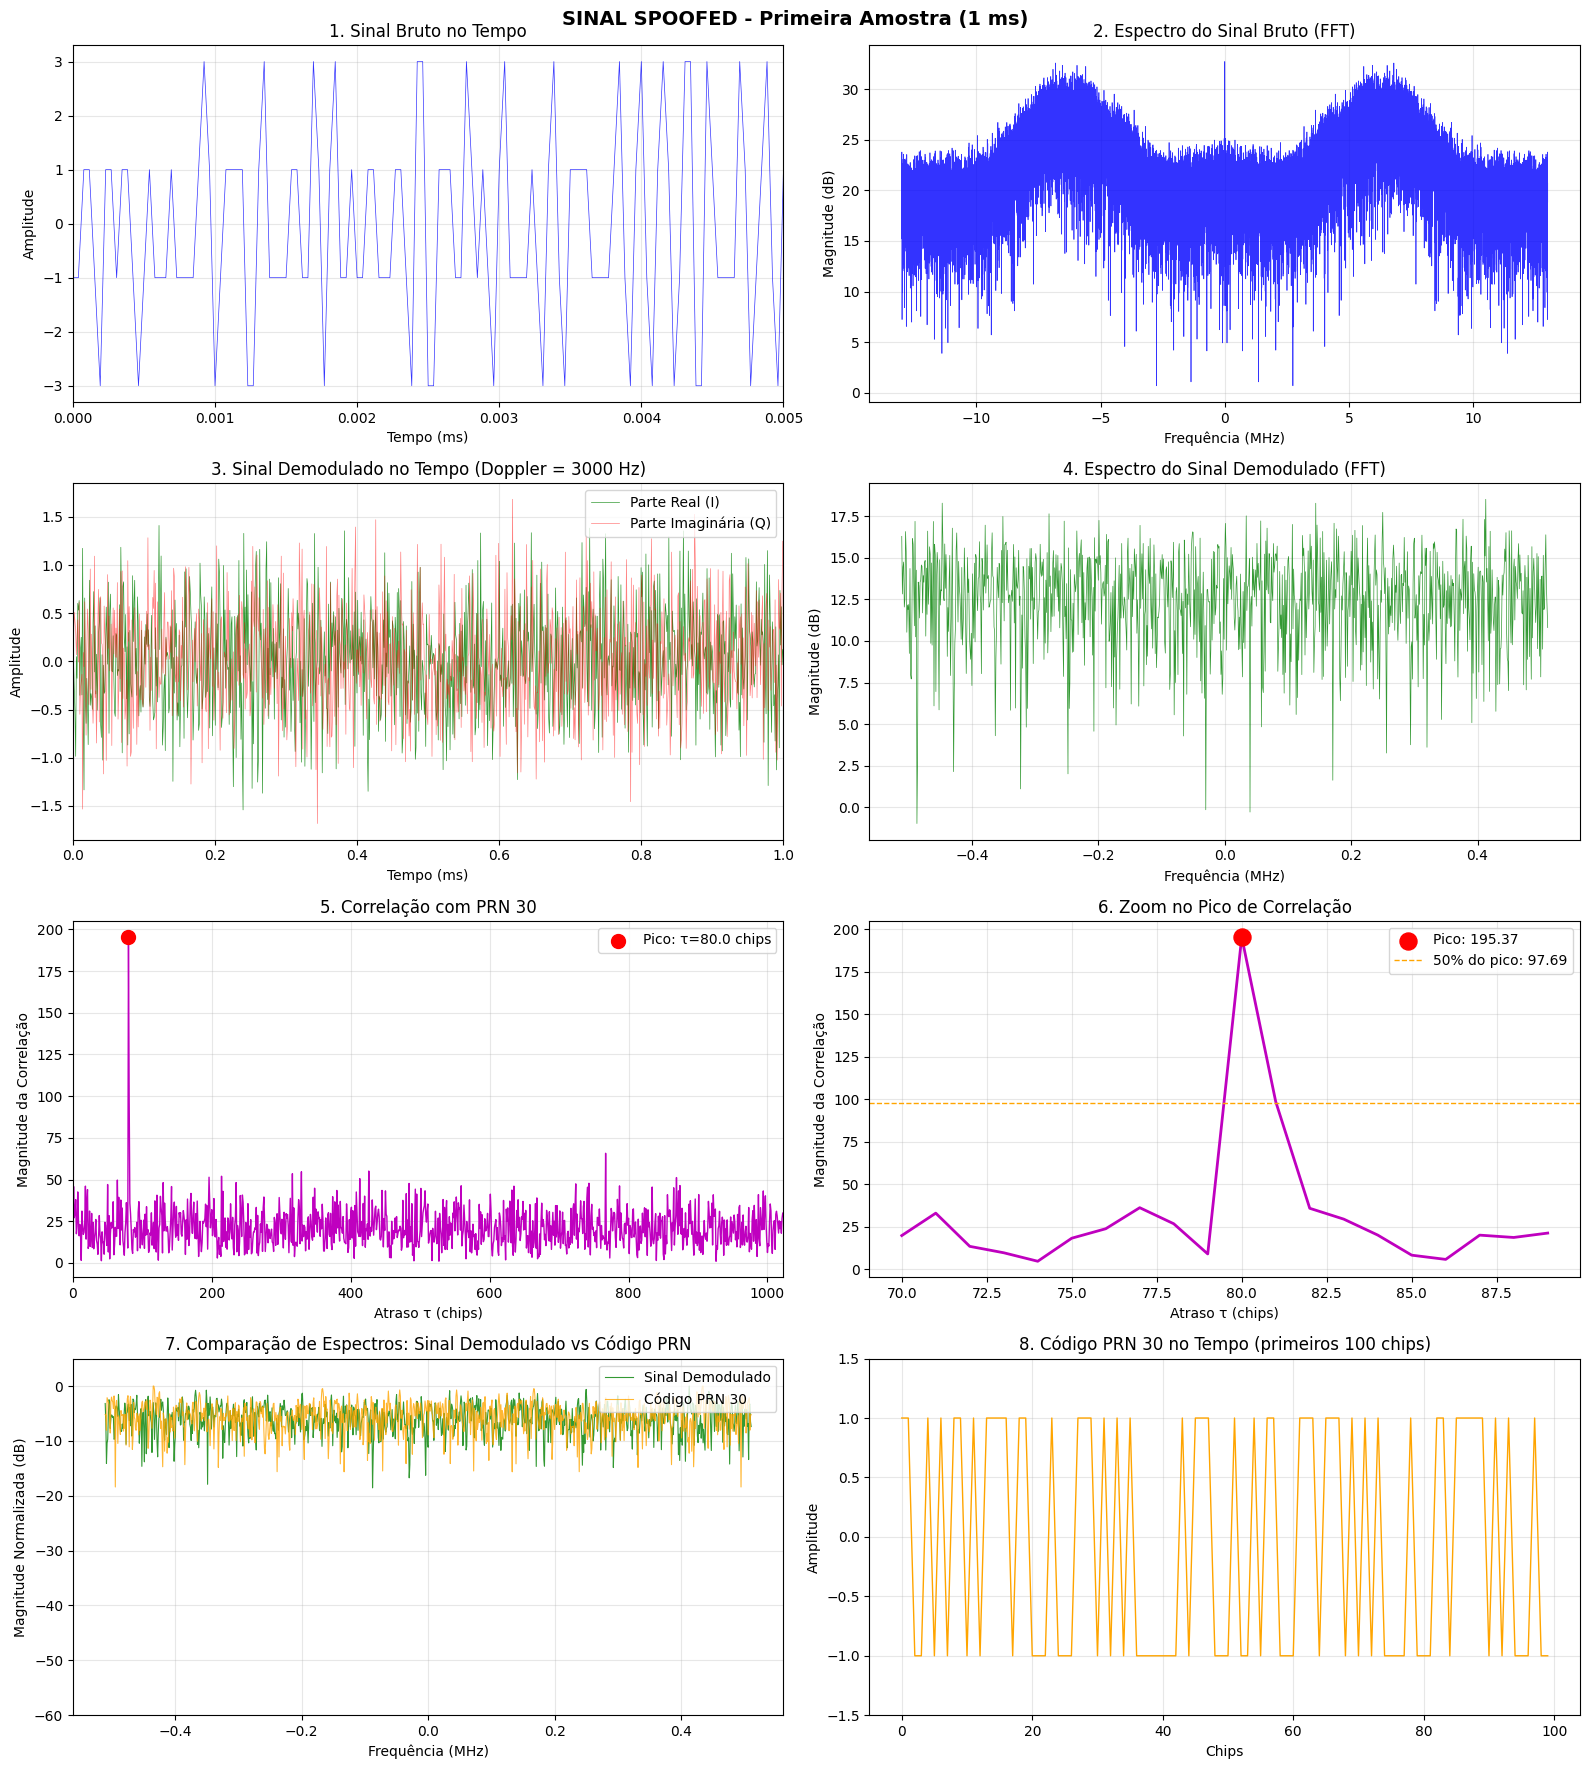


  MÉTRICAS DA PRIMEIRA AMOSTRA
  PRN detectado:        30
  Doppler:              3000 Hz
  Atraso τ:             80.00 chips
  Pico de correlação:   195.37
  SNR normalizado:      9.98
  Largura do pico:      2.00 chips
  Amostras processadas: 26000
  Duração:              1.00 ms



In [ ]:
def visualize_first_sample(filepath):

    print(f"\nVISUALIZAÇÃO DA PRIMEIRA AMOSTRA - {os.path.basename(filepath)}")

    filename = os.path.basename(filepath)
    
    if "clean" in filename:
        cfg = PARAMS_CLEAN
        title_prefix = "SINAL LIMPO (CLEAN)"
    elif "TGS" in filename:
        cfg = PARAMS_SPOOFED
        title_prefix = "SINAL SPOOFED"
    else:
        print("Erro: Tipo de arquivo não reconhecido")
        return
    
    BLOCK_TIME = 0.001  # 1 ms
    samples_per_block = int(cfg["FS"] * BLOCK_TIME)
    # samples_per_block = (samples_per_block // cfg["SAMPLES_PER_CODE"]) * cfg["SAMPLES_PER_CODE"]
    
    # Ler apenas a primeira amostra (1 bloco)
    try:
        if "TGS" in filename:
            # Para arquivos TGS, ler o final do arquivo onde o spoofing está estabelecido
            itemsize = np.dtype(cfg["DTYPE"]).itemsize
            offset_bytes = samples_per_block * itemsize
            
            with open(filepath, 'rb') as f:
                f.seek(0, 2) # Seek to end
                file_size = f.tell()
                if file_size >= offset_bytes:
                    f.seek(-offset_bytes, 2)
                    raw_data = np.fromfile(f, dtype=cfg["DTYPE"], count=samples_per_block)
                else:
                    f.seek(0)
                    raw_data = np.fromfile(f, dtype=cfg["DTYPE"], count=samples_per_block)
            print(f"Lendo último bloco ({len(raw_data)} amostras) do arquivo TGS.")
        else:
            raw_data = np.fromfile(filepath, dtype=cfg["DTYPE"], count=samples_per_block)
            print(f"Lendo primeiro bloco ({len(raw_data)} amostras) do arquivo Clean.")

        raw_data = raw_data.astype(np.float32)
    except FileNotFoundError:
        print(f"Erro: Arquivo '{filepath}' não encontrado.")
        return
    
    # Criar sinal complexo (apenas parte real, Q = 0)
    gps_signal = raw_data + 1j * np.zeros_like(raw_data)
    N = len(gps_signal)
    
    # Eixo de tempo
    t = np.arange(N) / cfg["FS"] * 1000
    
    # Eixo de frequência
    freq_axis = np.fft.fftshift(np.fft.fftfreq(N, d=1/cfg["FS"])) / 1e6
    
    # Gerar códigos PRN com 1023 amostras (1 amostra por chip)
    target_samples = 1023
    prn_codes = {}
    for prn in range(1, 33):
        prn_codes[prn] = generate_ca_code(prn, cfg["FS"], target_samples) # Usando target_samples aqui pode estar errado se generate_ca_code usa fs para calcular indices.
        # Na verdade, para gerar 1 amostra por chip exato, devemos passar fs=chip_rate ou ajustar a logica.
        # A logica ajustada em generate_ca_code usa t = np.arange(samples_per_code) / fs.
        # Se quisermos 1023 amostras, samples_per_code=1023.
        # Se fs for a original, t vai de 0 a 1023/fs, que é muito curto (não 1ms).
        # Para gerar o código correto com 1023 amostras representando 1ms, devemos usar fs = 1.023e6 (chip rate)
        prn_codes[prn] = generate_ca_code(prn, 1.023e6, target_samples)
    
    doppler_freqs = np.arange(-cfg["DOPPLER_RANGE"], cfg["DOPPLER_RANGE"] + cfg["DOPPLER_STEP"], cfg["DOPPLER_STEP"])

    # Buscar melhor PRN e Doppler
    print("Buscando melhor PRN e Doppler...")
    max_correlation_value = 0.0
    best_doppler = 0.0
    best_prn = 0
    best_code_replica = None
    best_correlation = None
    best_band_base = None
    
    for prn in range(1, 33):
        local_code_chips = prn_codes[prn]
        local_code_replica = local_code_chips # Sem tile, pois agora é 1ms exato com 1023 amostras
        
        for doppler in doppler_freqs:
            FC_local = cfg["FC"] + doppler
            band_base_signal_high_res = demodulate(gps_signal, N, cfg["FS"], FC_local)

            # Downsample para 1023 amostras
            band_base_signal = signal.resample(band_base_signal_high_res, target_samples)

            correlation_magnitude = correlate_signals(band_base_signal, local_code_replica)
            current_max = np.max(correlation_magnitude)
            
            if current_max > max_correlation_value:
                max_correlation_value = current_max
                best_doppler = doppler
                best_prn = prn
                best_code_replica = local_code_replica.copy()
                best_correlation = correlation_magnitude.copy()
                best_band_base = band_base_signal.copy()
    
    print(f"Melhor PRN encontrado: {best_prn}")
    print(f"Melhor Doppler: {best_doppler} Hz")
    print(f"Valor máximo de correlação: {max_correlation_value:.2f}")
    
    # ========== CRIAR FIGURA COM 8 SUBPLOTS (4x2) ==========
    fig, axes = plt.subplots(4, 2, figsize=(16, 18))
    fig.suptitle(f'{title_prefix} - Primeira Amostra (1 ms)', fontsize=14, fontweight='bold')
    
    # ========== 1. SINAL NO TEMPO (RAW) ==========
    ax1 = axes[0, 0]
    ax1.plot(t, np.real(gps_signal), 'b-', linewidth=0.5, alpha=0.8)
    ax1.set_xlabel('Tempo (ms)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('1. Sinal Bruto no Tempo')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 0.005])
    
    # ========== 2. SINAL NA FREQUÊNCIA (FFT) ==========
    ax2 = axes[0, 1]
    fft_raw = np.fft.fftshift(np.fft.fft(gps_signal))
    spectrum_raw = 10 * np.log10(np.abs(fft_raw) + 1e-10)
    ax2.plot(freq_axis, spectrum_raw, 'b-', linewidth=0.5, alpha=0.8)
    ax2.set_xlabel('Frequência (MHz)')
    ax2.set_ylabel('Magnitude (dB)')
    ax2.set_title('2. Espectro do Sinal Bruto (FFT)')
    ax2.grid(True, alpha=0.3)
    
    # ========== 3. SINAL DEMODULADO NO TEMPO ==========
    # Ajustar eixo de tempo para o sinal downsampled (1023 amostras em 1ms)
    t_downsampled = np.arange(target_samples) / 1.023e6 * 1000 # ms
    
    ax3 = axes[1, 0]
    ax3.plot(t_downsampled, np.real(best_band_base), 'g-', linewidth=0.5, alpha=0.8, label='Parte Real (I)')
    ax3.plot(t_downsampled, np.imag(best_band_base), 'r-', linewidth=0.5, alpha=0.5, label='Parte Imaginária (Q)')
    ax3.set_xlabel('Tempo (ms)')
    ax3.set_ylabel('Amplitude')
    ax3.set_title(f'3. Sinal Demodulado no Tempo (Doppler = {best_doppler} Hz)')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, 1.0]) # 1ms
    
    # ========== 4. SINAL DEMODULADO NA FREQUÊNCIA ==========
    ax4 = axes[1, 1]
    fft_demod = np.fft.fftshift(np.fft.fft(best_band_base))
    # Eixo de frequencia para o sinal downsampled (fs = 1.023 MHz)
    freq_axis_demod = np.fft.fftshift(np.fft.fftfreq(target_samples, d=1/1.023e6)) / 1e6
    
    spectrum_demod = 10 * np.log10(np.abs(fft_demod) + 1e-10)
    ax4.plot(freq_axis_demod, spectrum_demod, 'g-', linewidth=0.5, alpha=0.8)
    ax4.set_xlabel('Frequência (MHz)')
    ax4.set_ylabel('Magnitude (dB)')
    ax4.set_title('4. Espectro do Sinal Demodulado (FFT)')
    ax4.grid(True, alpha=0.3)
    
    # ========== 5. CORRELAÇÃO COM MELHOR PRN ==========
    ax5 = axes[2, 0]
    # Samples per chip agora é 1
    tau_axis = np.arange(len(best_correlation)) # Já está em chips
    ax5.plot(tau_axis, best_correlation, 'm-', linewidth=1)
    
    # Marcar o pico
    peak_idx = np.argmax(best_correlation)
    peak_tau = peak_idx # Já está em chips
    peak_val = best_correlation[peak_idx]
    ax5.scatter(peak_tau, peak_val, color='red', s=100, zorder=5, 
                label=f'Pico: τ={peak_tau:.1f} chips')
    
    ax5.set_xlabel('Atraso τ (chips)')
    ax5.set_ylabel('Magnitude da Correlação')
    ax5.set_title(f'5. Correlação com PRN {best_prn}')
    ax5.legend(loc='upper right')
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim([0, cfg["PRN_LENGTH"]])
    
    # ========== 6. ZOOM NO PICO DE CORRELAÇÃO ==========
    ax6 = axes[2, 1]
    
    # Zoom: ±10 chips ao redor do pico
    zoom_chips = 10
    zoom_samples = int(zoom_chips * 1) # samples_per_chip = 1
    start_idx = max(0, peak_idx - zoom_samples)
    end_idx = min(len(best_correlation), peak_idx + zoom_samples)
    
    tau_zoom = tau_axis[start_idx:end_idx]
    corr_zoom = best_correlation[start_idx:end_idx]
    
    ax6.plot(tau_zoom, corr_zoom, 'm-', linewidth=2)
    ax6.scatter(peak_tau, peak_val, color='red', s=150, zorder=5, 
                label=f'Pico: {peak_val:.2f}')
    
    # Linha de 50% do pico (largura de correlação)
    half_peak = peak_val * 0.5
    ax6.axhline(y=half_peak, color='orange', linestyle='--', linewidth=1, 
                label=f'50% do pico: {half_peak:.2f}')
    
    ax6.set_xlabel('Atraso τ (chips)')
    ax6.set_ylabel('Magnitude da Correlação')
    ax6.set_title(f'6. Zoom no Pico de Correlação')
    ax6.legend(loc='upper right')
    ax6.grid(True, alpha=0.3)
    
    # ========== 7. COMPARAÇÃO ESPECTRO: SINAL DEMODULADO vs CÓDIGO PRN ==========
    ax7 = axes[3, 0]
    
    # Aplicar janela de Hanning para visualização
    window = np.hanning(target_samples)
    
    # FFT do sinal demodulado (com janela)
    fft_demod_windowed = np.fft.fftshift(np.fft.fft(best_band_base * window))
    spectrum_demod_windowed = 10 * np.log10(np.abs(fft_demod_windowed) + 1e-10)
    
    # FFT do código PRN (com janela)
    fft_prn = np.fft.fftshift(np.fft.fft(best_code_replica * window))
    spectrum_prn = 10 * np.log10(np.abs(fft_prn) + 1e-10)
    
    # Normalizar para comparação (trazer para mesma escala)
    spectrum_demod_norm = spectrum_demod_windowed - np.max(spectrum_demod_windowed)
    spectrum_prn_norm = spectrum_prn - np.max(spectrum_prn)
    
    ax7.plot(freq_axis_demod, spectrum_demod_norm, 'g-', linewidth=0.8, alpha=0.8, label='Sinal Demodulado')
    ax7.plot(freq_axis_demod, spectrum_prn_norm, 'orange', linewidth=0.8, alpha=0.8, label=f'Código PRN {best_prn}')
    ax7.set_xlabel('Frequência (MHz)')
    ax7.set_ylabel('Magnitude Normalizada (dB)')
    ax7.set_title('7. Comparação de Espectros: Sinal Demodulado vs Código PRN')
    ax7.legend(loc='upper right')
    ax7.grid(True, alpha=0.3)
    ax7.set_ylim([-60, 5])
    
    # ========== 8. CÓDIGO PRN NO TEMPO ==========
    ax8 = axes[3, 1]
    
    # Mostrar apenas os primeiros 100 chips do código PRN
    chips_to_show = 100
    samples_to_show = int(chips_to_show * 1) # samples_per_chip = 1
    t_prn = np.arange(samples_to_show) # chips
    
    ax8.plot(t_prn, best_code_replica[:samples_to_show], 'orange', linewidth=1)
    ax8.set_xlabel('Chips')
    ax8.set_ylabel('Amplitude')
    ax8.set_title(f'8. Código PRN {best_prn} no Tempo (primeiros {chips_to_show} chips)')
    ax8.set_ylim([-1.5, 1.5])
    ax8.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========== INFORMAÇÕES ADICIONAIS ==========
    # Normalizar correlação
    corr_norm, peak_snr, phase = normalize_correlation_by_noise(
        best_correlation, target_samples, cfg['PRN_LENGTH']
    )
    
    # Calcular largura do pico
    above_half = best_correlation > half_peak
    correlation_width = np.sum(above_half) # samples_per_chip = 1
    
    print(f"\n{'='*50}")
    print(f"  MÉTRICAS DA PRIMEIRA AMOSTRA")
    print(f"{'='*50}")
    print(f"  PRN detectado:        {best_prn}")
    print(f"  Doppler:              {best_doppler} Hz")
    print(f"  Atraso τ:             {peak_tau:.2f} chips")
    print(f"  Pico de correlação:   {peak_val:.2f}")
    print(f"  SNR normalizado:      {peak_snr:.2f}")
    print(f"  Largura do pico:      {correlation_width:.2f} chips")
    print(f"  Amostras processadas: {N}")
    print(f"  Duração:              {N/cfg['FS']*1000:.2f} ms")
    print(f"{'='*50}\n")
    
    return {
        'prn': best_prn,
        'doppler': best_doppler,
        'tau_chips': peak_tau,
        'peak_value': peak_val,
        'peak_snr': peak_snr,
        'correlation_width': correlation_width
    }


# Testar com os dois arquivos
print("\n" + "="*70)
print("  ANÁLISE DA PRIMEIRA AMOSTRA - SINAL LIMPO")
print("="*70)
FILENAME_CLEAN = '/home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat'
metrics_clean_sample = visualize_first_sample(FILENAME_CLEAN)

print("\n" + "="*70)
print("  ANÁLISE DA PRIMEIRA AMOSTRA - SINAL SPOOFED")
print("="*70)
FILENAME_SPOOFED = '/home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat'
metrics_spoofed_sample = visualize_first_sample(FILENAME_SPOOFED)
